This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.stats as st
from scipy.spatial import ConvexHull, distance_matrix
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import math
import random
from abc import ABC, abstractmethod
from typing import Union

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

In [5]:
class DatasetGenerator(ABC):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()
    
    @abstractmethod
    def refresh(self):
        pass

In [6]:
class G1(DatasetGenerator):
    def refresh(self):
        self.x = np.random.rand(self.N, 2)
        self.v = np.random.rand(self.N)

In [7]:
class G2(DatasetGenerator):
    def refresh(self):
        self.x = np.random.rand(self.N, 2)
        self.v = np.exp(np.random.randn(self.N) * 1.3 - 0.85)

---

### Metropolis Hastings - 1

In [8]:
def getOptBetaSeq(generator_name: str, lambda_: Union[int, float, str]):
    beta_lookup_table = pd.read_csv('G1_and_G2_optimal_betas.csv')
    if generator_name in ('G1', 'G2'):
        aval_lambdas = pd.unique(beta_lookup_table[beta_lookup_table.model == generator_name]['lambda'])
        correct_lambda = aval_lambdas[np.argmin(np.abs(aval_lambdas - lambda_))]
        print(f'Original lambda is {lambda_} Corrected one is {correct_lambda}')
        
        betas = beta_lookup_table.query("(model == @generator_name) & (`lambda` == @correct_lambda)")
        return sorted(betas.beta)
    else:
        aval_lambdas = pd.unique(beta_lookup_table[beta_lookup_table.model == 'G1']['lambda'])
        correct_lambda = aval_lambdas[np.argmin(np.abs(aval_lambdas - lambda_))]
        betas1 = beta_lookup_table.query("(model == 'G1') & (`lambda` == @correct_lambda)")
        
        aval_lambdas = pd.unique(beta_lookup_table[beta_lookup_table.model == 'G2']['lambda'])
        correct_lambda = aval_lambdas[np.argmin(np.abs(aval_lambdas - lambda_))]
        betas2 = beta_lookup_table.query("(model == 'G2') & (`lambda` == @correct_lambda)")
        allbeta = np.array([sorted(betas1.beta), sorted(betas2.beta)])
        
        return np.mean(allbeta, axis=0)

In [9]:
def interpBetas(betas, steps, smooth=True):
    if steps <= len(betas):
        return betas
    # interpolation
    xp = np.linspace(0, steps - 1, num=len(betas))
    xp = np.int32(xp)
    beta_full =  np.interp(np.arange(steps), xp, betas)
    if not smooth:
        return beta_full
    
    # smooth with least square
    x = np.arange(len(beta_full))
    A = np.vstack([x, np.ones(len(x))]).T
    y = np.log(beta_full)
    coef, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    smoothed = np.exp(coef[0] * x + coef[1])
    return smoothed

In [10]:
from MH import optimizer, maximize

In [11]:
@maximize
def objective(v, x, lam, state):
    indicator = state
    n = len(indicator)
#     assert len(v) == n
#     assert x.shape == (n, 2)
    
    def diameter(array):
        hull = ConvexHull(array, incremental=False)
        edges = array[hull.vertices]
        diam = np.max(distance_matrix(edges, edges))
        return diam
    
    population = np.sum(v * indicator)
    cities = x[indicator]
    radius = diameter(cities) / 2
    area = math.pi * radius ** 2
    
    obj = population - lam * n * area
    return obj

def transition(state):
    ind = random.randint(0, len(state) - 1)
    new_state = np.copy(state)
    new_state[ind] = not state[ind]
    return new_state

In [12]:
lam = 1
beta_schedule = getOptBetaSeq('G2', lam)
beta = beta_schedule[0]

Original lambda is 1 Corrected one is 1.0


In [13]:
random.seed(20)
np.random.seed(20)
g2 = G2(100)
g2.refresh()

In [14]:
inputs = {'v': g2.v, 'x': g2.x, 'lam': lam}
init_state = np.random.randint(0, 2, size=len(g2.v), dtype=bool)
optim = optimizer(objective, transition, beta, init_state, **inputs)

num_iters = 5000
val, num_cities = optim.run(iters=num_iters, beta_schedule=beta_schedule, reset=True)

In [15]:
np.max(val)

-25.885992836183533

<Figure size 800x480 with 0 Axes>

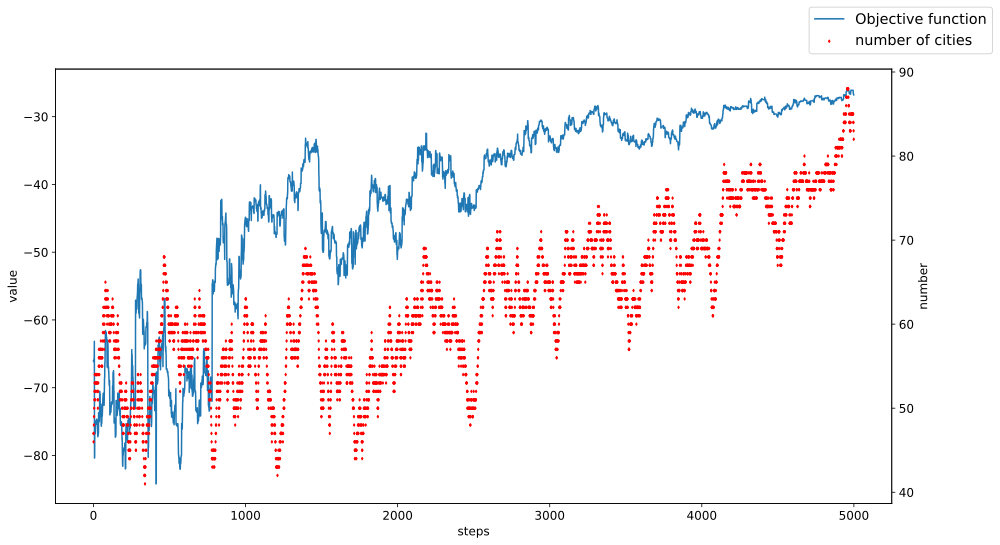

In [16]:
plt.clf()
steps = range(num_iters)
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 8)
ax1.plot(range(num_iters), val, label='Objective function')
ax1.set_xlabel('steps')
ax1.set_ylabel('value')


ax2 = ax1.twinx()
ax2.scatter(range(num_iters), num_cities, s=3, marker='d', color='r', label='number of cities')
ax2.set_ylabel('number')
fig.legend()

In [17]:
random.seed(20)
np.random.seed(20)
g2 = G2(100)
g2.refresh()

In [18]:
inputs = {'v': g2.v, 'x': g2.x, 'lam': lam}
init_state = np.random.randint(0, 2, size=len(g2.v), dtype=bool)
optim = optimizer(objective, transition, beta, init_state, **inputs)

num_iters = 5000
beta_interp = interpBetas(beta_schedule, num_iters, smooth=False)
val, num_cities = optim.run(iters=num_iters, beta_schedule=beta_interp, reset=True)

In [19]:
np.max(val)

-25.834360610174784

<Figure size 800x480 with 0 Axes>

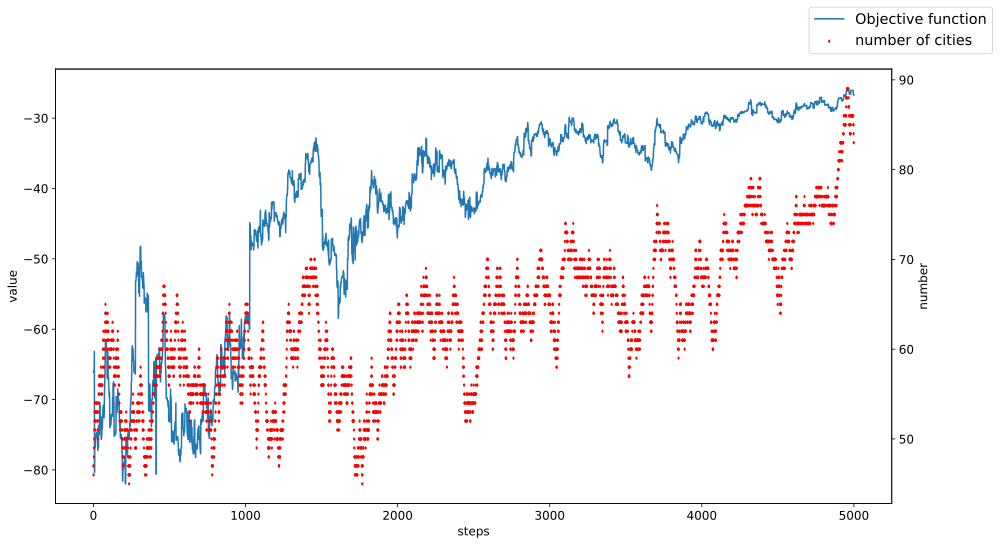

In [20]:
plt.clf()
steps = range(num_iters)
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 8)
ax1.plot(range(num_iters), val, label='Objective function')
ax1.set_xlabel('steps')
ax1.set_ylabel('value')


ax2 = ax1.twinx()
ax2.scatter(range(num_iters), num_cities, s=3, marker='d', color='r', label='number of cities')
ax2.set_ylabel('number')
fig.legend()

In [25]:
random.seed(20)
np.random.seed(20)
g2 = G2(100)
g2.refresh()

In [26]:
inputs = {'v': g2.v, 'x': g2.x, 'lam': lam}
init_state = np.random.randint(0, 2, size=len(g2.v), dtype=bool)
optim = optimizer(objective, transition, beta, init_state, **inputs)

num_iters = 5000
beta_interp = interpBetas(beta_schedule, num_iters, smooth=True)
val, num_cities = optim.run(iters=num_iters, beta_schedule=beta_interp, reset=True)

In [27]:
np.max(val)

-26.581543319298945

<Figure size 800x480 with 0 Axes>

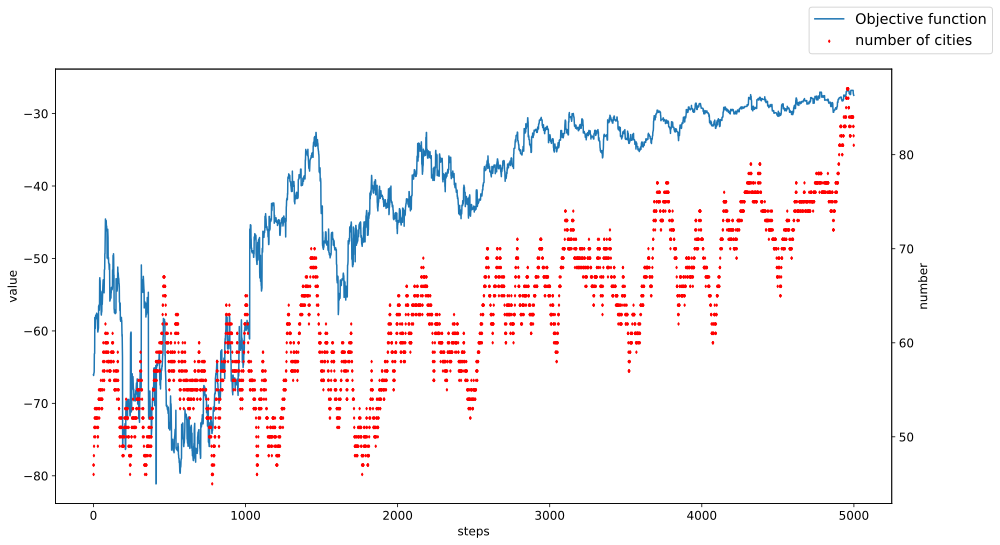

In [28]:
plt.clf()
steps = range(num_iters)
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 8)
ax1.plot(range(num_iters), val, label='Objective function')
ax1.set_xlabel('steps')
ax1.set_ylabel('value')


ax2 = ax1.twinx()
ax2.scatter(range(num_iters), num_cities, s=3, marker='d', color='r', label='number of cities')
ax2.set_ylabel('number')
fig.legend()

---